## Imports

In [ ]:
!pip install segment_anything
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageOps
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from segment_anything import sam_model_registry, SamPredictor

!pip install 'git+https://github.com/facebookresearch/segment-anything.git' transformers opencv-python matplotlib
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

ERROR: Operation cancelled by user
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0aow1ohu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0aow1ohu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-05-22 02:48:42--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.15, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   150MB/s    in 22s     

2025-05-22 02:49:04 (112 MB/s) - ‘sam_vit_h_4b8939.pth

## Preprocessing

In [ ]:
device=torch.device("cuda")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
detector  = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)

sys.path.append("..")
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

sam.to(device=device)
predictor = SamPredictor(sam)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

## OWL ViT object detection using open prompt

In [ ]:
def bounding_box_detection(inputimg, prompt, threshold = 0.001):
  img_pil = Image.open(inputimg).convert("RGB")
  img_pil = ImageOps.exif_transpose(img_pil)
  img = np.array(img_pil)

  inputs = processor(text=[prompt], images=[img_pil], return_tensors="pt").to(device)
  with torch.no_grad():
    outputs = detector(**inputs)


  target_sizes = torch.tensor([img_pil.size[::-1]], device=device)
  results = processor.post_process_object_detection(
    outputs, threshold, target_sizes=target_sizes
  )[0]

  boxes = results["boxes"].cpu().numpy()
  scores = results["scores"].cpu().numpy()

  print(f"Found {len(boxes)} objects")
  if len(boxes) == 0:
    return -1
  else:
    best_idx = scores.argmax()
    x0, y0, x1, y1 = boxes[best_idx].astype(int)
    box = np.array([x0, y0, x1, y1])

    print(f"Selected box {box} with score {scores[best_idx]:.3f}")
    return box


## Applying a segmask using Meta SAM

In [ ]:
def generate_segmask(inputimg, box, imgpath):
  if isinstance(box, int):
    return "noimagelikethatfound.png"

  img = cv2.imread(inputimg)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  predictor.set_image(img)
  masks, mask_scores, _ = predictor.predict(
      box=np.expand_dims(box, axis=0),
      multimask_output=False
  )
  mask = masks[0]

  alpha = (mask.astype(np.uint8) * 255)
  rgba  = np.dstack([img, alpha])


  imgpath = imgpath if imgpath else "sticker.png"
  sticker = Image.fromarray(rgba)
  sticker.save(imgpath)
  print(f"Saved → {imgpath}")

  return imgpath


## Main function (editable inputs)

Enter full image path
/content/bros.jpg
Enter a prompt of what to extract from the image
adult
Enter the path of the output image (optional, saves to sticker.png)



/usr/local/lib/python3.11/dist-packages/transformers/models/owlvit/processing_owlvit.py:233: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


Found 36 objects
Selected box [ 170  631  925 1604] with score 0.014
Saved → sticker.png


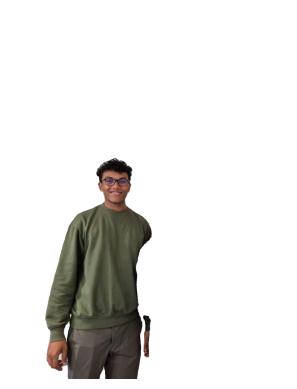

In [ ]:
inputpath = input("Enter full image path\n")
prompt = input("Enter a prompt of what to extract from the image\n")
outputpath = input("Enter the path of the output image (optional, saves to sticker.png)\n")
box = bounding_box_detection(inputpath, prompt)
imgpath = generate_segmask(inputpath, box, outputpath)

img = Image.open(imgpath)
plt.imshow(img)
plt.axis('off')
plt.show()

# Segment and Sticker


## Outputs by varying OwlViT prompts vs. thresholds

##### Here is an image of a car parked outside the college library that we are using as input

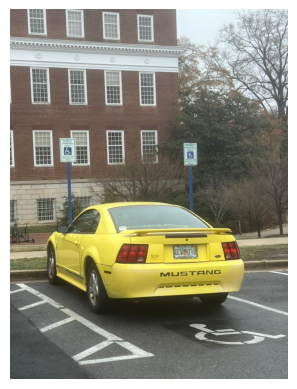

In [ ]:
img = Image.open("car.jpeg")
plt.imshow(img)
plt.axis('off')
plt.show()


##### Constant threshold but varying prompt specificity

A threshold of above 0.25 makes it so that adjectives/specifics of the object are required to successfully create a mask of the object

/usr/local/lib/python3.11/dist-packages/transformers/models/owlvit/processing_owlvit.py:233: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


Found 0 objects
Found 1 objects
Selected box [ 152  826 1004 1318] with score 0.786
Saved → sticker.png


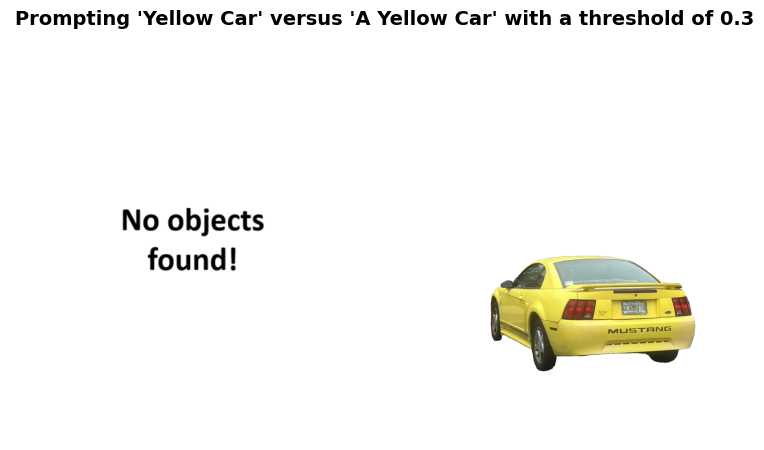

In [ ]:
# A hyper specific input is required for high thresholds, which is not ideal for prompt complacency (human tendency to shorten prompts)

box = bounding_box_detection("car.jpeg", "yellow car", 0.3)
img1 = generate_segmask("car.jpeg", box, "")

box = bounding_box_detection("car.jpeg", "a yellow car", 0.3)
img2 = generate_segmask("car.jpeg", box, "")

im1 = Image.open(img1)
im2 = Image.open(img2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(im1)
axs[0].axis('off')
axs[1].imshow(im2)
axs[1].axis('off')
plt.suptitle("Prompting 'Yellow Car' versus 'A Yellow Car' with a threshold of 0.3", fontsize=14, y=0.97, weight='bold')
plt.show()

We use a constant low threshold (reduced by a factor of 10x) and it is able to capture real world references, such as 'Mustang'

Found 1 objects
Selected box [ 152  826 1004 1318] with score 0.114
Saved → sticker.png
Found 1 objects
Selected box [ 152  826 1004 1318] with score 0.033
Saved → sticker.png


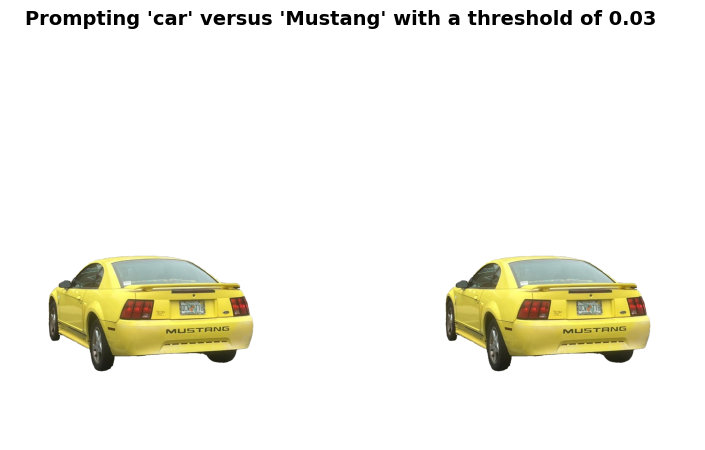

In [ ]:
# Now, we reduce the threshold, but there is definitely a confidence difference (0.114 vs 0.033)
box = bounding_box_detection("car.jpeg", "car", 0.03)
img1 = generate_segmask("car.jpeg", box, "")

box = bounding_box_detection("car.jpeg", "Mustang", 0.03)
img2 = generate_segmask("car.jpeg", box, "")

im1 = Image.open(img1)
im2 = Image.open(img2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(im1)
axs[0].axis('off')
axs[1].imshow(im2)
axs[1].axis('off')
plt.suptitle("Prompting 'car' versus 'Mustang' with a threshold of 0.03", fontsize=14, y=0.97, weight='bold')
plt.show()

Using a constant low threshold still changes according to the adjective/ specificity of the prompt leading to some weird observations

##### Keeping prompts constant but varying the threshold (particularly for external objects)

Windows (background object) not detected very well due to higher thresholds

Found 0 objects
Found 2 objects
Selected box [ -9  10 765 953] with score 0.014
Saved → sticker.png
Found 54 objects
Selected box [ -9  10 765 953] with score 0.014
Saved → sticker.png


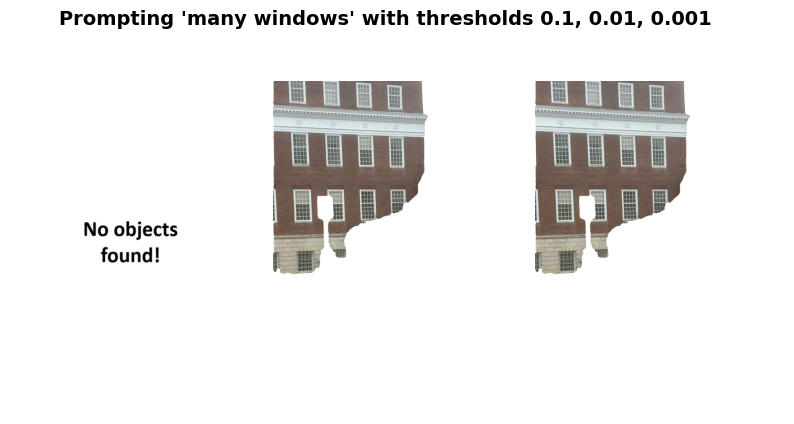

In [ ]:

box = bounding_box_detection("car.jpeg", "many windows", 0.1)
img1 = generate_segmask("car.jpeg", box, "")

box2 = bounding_box_detection("car.jpeg", "many windows", 0.01)
img2 = generate_segmask("car.jpeg", box2, "")

box = bounding_box_detection("car.jpeg", "many windows", 0.001)
img3 = generate_segmask("car.jpeg", box, "")

im1 = Image.open(img1)
im2 = Image.open(img2)
im3 = Image.open(img3)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(im1)
axs[0].axis('off')
axs[1].imshow(im2)
axs[1].axis('off')
axs[2].imshow(im3)
axs[2].axis('off')
plt.suptitle("Prompting 'many windows' with thresholds 0.1, 0.01, 0.001", fontsize=14, y=0.97, weight='bold')
plt.show()

A good case of specific prompt and a decent threshold!

Found 0 objects
Found 6 objects
Selected box [ 785 1358 1192 1450] with score 0.059
Saved → sticker.png
Found 73 objects
Selected box [ 785 1358 1192 1450] with score 0.059
Saved → sticker.png


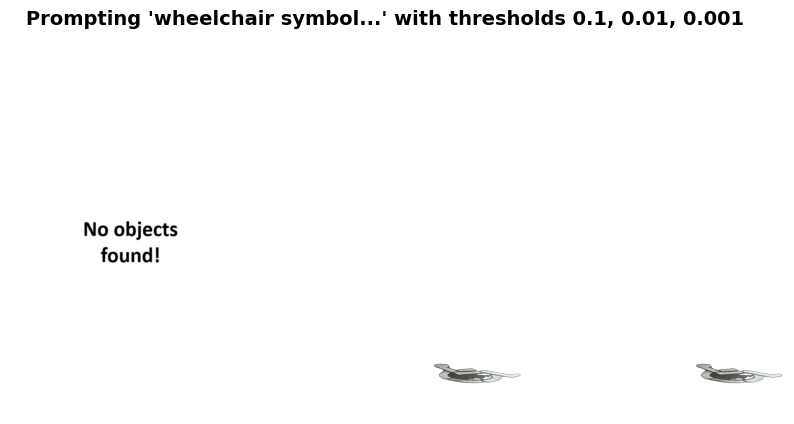

In [ ]:
box = bounding_box_detection("car.jpeg", "wheelchair symbol on the road", 0.1)
img1 = generate_segmask("car.jpeg", box, "")

box2 = bounding_box_detection("car.jpeg", "wheelchair symbol on the road", 0.01)
img2 = generate_segmask("car.jpeg", box2, "")

box = bounding_box_detection("car.jpeg", "wheelchair symbol on the road", 0.001)
img3 = generate_segmask("car.jpeg", box, "")

im1 = Image.open(img1)
im2 = Image.open(img2)
im3 = Image.open(img3)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(im1)
axs[0].axis('off')
axs[1].imshow(im2)
axs[1].axis('off')
axs[2].imshow(im3)
axs[2].axis('off')
plt.suptitle("Prompting 'wheelchair symbol...' with thresholds 0.1, 0.01, 0.001", fontsize=14, y=0.97, weight='bold')
plt.show()

##Inability to detect two principal objects (specific to people!)

From practice (and the above examples) we see that multiple parts of the same image seem to be detected very well using a threshold of 0.01

Here's some images involving two principal subjects!

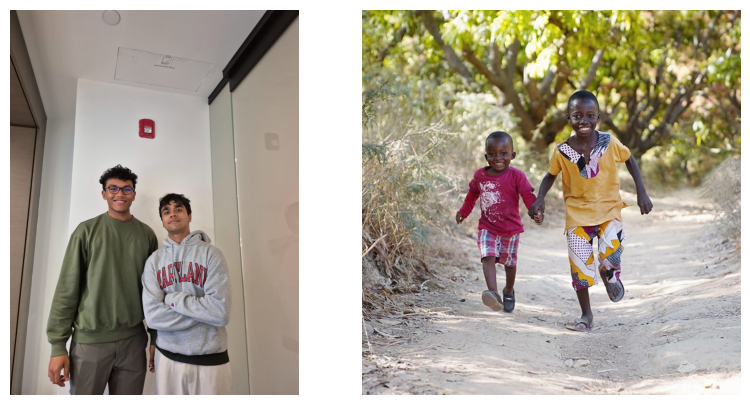

In [ ]:
im1 = Image.open("bros.jpg")
im2 = Image.open("children.jpg")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(im1)
axs[0].axis('off')
axs[1].imshow(im2)
axs[1].axis('off')
plt.show()

Found 1 objects
Selected box [ 170  631  925 1604] with score 0.022
Saved → a.png
Found 6 objects
Selected box [172 151 511 586] with score 0.060
Saved → b.png


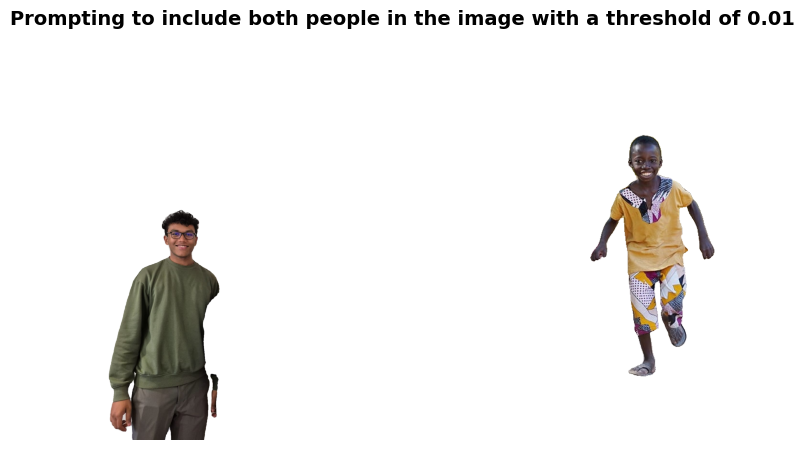

In [ ]:
box = bounding_box_detection("bros.jpg", "both people", 0.01)
img1 = generate_segmask("bros.jpg", box, "a.png")

box = bounding_box_detection("children.jpg", "both children", 0.01)
img2 = generate_segmask("children.jpg", box, "b.png")

im1 = Image.open(img1)
im2 = Image.open(img2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(im1)
axs[0].axis('off')
axs[1].imshow(im2)
axs[1].axis('off')
plt.suptitle("Prompting to include both people in the image with a threshold of 0.01", fontsize=14, y=0.97, weight='bold')
plt.show()

But it works perfectly fine with some carrots?

/usr/local/lib/python3.11/dist-packages/transformers/models/owlvit/processing_owlvit.py:233: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


Found 12 objects
Selected box [ 20  59 146 137] with score 0.070
Saved → d.png
Found 9 objects
Selected box [ 17  20 236 154] with score 0.071
Saved → c.png


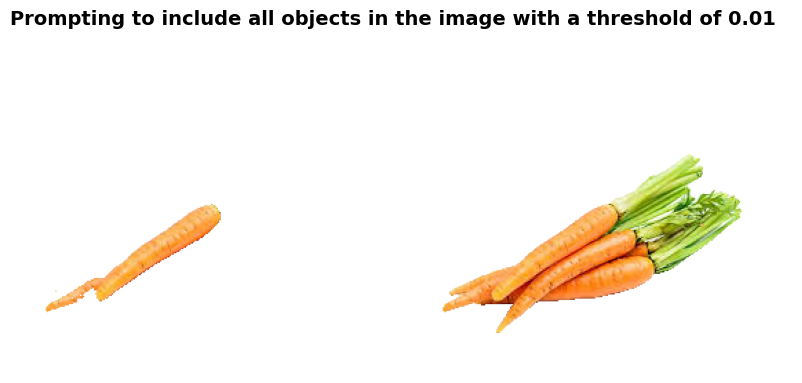

In [ ]:
box = bounding_box_detection("carrots.jpg", "carrot", 0.01)
img1 = generate_segmask("carrots.jpg", box, "d.png")

box = bounding_box_detection("carrots.jpg", "carrots", 0.01)
img2 = generate_segmask("carrots.jpg", box, "c.png")

im1 = Image.open(img1)
im2 = Image.open(img2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.subplots_adjust(wspace=0.05)
axs[0].imshow(im1)
axs[0].axis('off')
axs[1].imshow(im2)
axs[1].axis('off')
plt.suptitle("Prompting to include all objects in the image with a threshold of 0.01", fontsize=14, y=0.97, weight='bold')
plt.show()